In [1]:
from biodatatools.utils.common import json_load
import pandas as pd
from collections import defaultdict
import subprocess
from scipy import stats
from statsmodels.stats import multitest
import numpy as np
import pybedtools
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from pathlib import Path

In [2]:
matplotlib.font_manager.fontManager.addfont(f"{Path.cwd().parent}/font/Arial.ttf")
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [3]:
PROJECT_DIR_d = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/PROcap/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/"

# Get ChIP-seq signals at peak regions

In [4]:
s = "C1"
ps = ["divergent", "unidirectional"]
ds = ["distal", "proximal"]
gs = [f"{p}_{d}" for p, d in itertools.product(ps, ds)]

In [5]:
acc_target = json_load(f"{PROJECT_DIR_r}ENCODE/acc_target.json")

In [6]:
fb = " ".join([f"{PROJECT_DIR_r}ENCODE/{acc}.bed.gz" for acc in acc_target])
for g in gs:
	fa = f"{PROJECT_DIR_d}bed_plot/{s}_{g}.bed"
	outputfile = f"{PROJECT_DIR_o}temp/{s}_{g}_ChIP.bed"
	commands = " ".join(["bedtools intersect",
						 "-a", fa,
						 "-b", fb,
						 "-wao",
						 ">", outputfile
						])
	subprocess.run(commands, shell=True)

In [7]:
# Column 0-7: PRO-cap peak files
# Column 8: ChIP-seq file number from which the overlap came; the number (1-based) corresponds to the order in which the files were given on the command line
# Column 9-18: ChIP-seq files (ENCODE narrowPeak file format: https://genome.ucsc.edu/FAQ/FAQformat.html#format12)
# Column 19: the overlap length

inputfile = f"{PROJECT_DIR_o}temp/{s}_{g}_ChIP.bed"
df = pd.read_table(inputfile, header=None, low_memory=False)
df.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,chr1,975962,976463,976227,976241,976240,.,+,9,chr1,976138,976350,.,1000,.,79.55370,-1.00000,4.65032,93,212
1,chr1,975962,976463,976227,976241,976240,.,+,24,chr1,976147,976303,.,1000,.,99.05771,-1.00000,4.94655,70,156


In [8]:
# Get signals at each element for each ChIP-seq file

values = {g: defaultdict(dict) for g in gs}
for g in gs:
    inputfile = f"{PROJECT_DIR_o}temp/{s}_{g}_ChIP.bed"
    df = pd.read_table(inputfile, header=None, low_memory=False)
    for _, row in df.iterrows():
        if int(row[19]) > 0:
            chrom, start, end = row[:3]
            acc = list(acc_target.keys())[int(row[8]) - 1]
            signalValue = float(row[15])
            values[g][(chrom, start, end)].setdefault(acc, []).append(signalValue)

# ChIP-seq signal enrichment

## Calculate enrichment

In [21]:
es = {}
for g in gs:
	b = pybedtools.BedTool(f"{PROJECT_DIR_d}bed_plot/{s}_{g}.bed")
	es[g] = [(i.fields[0], int(i.fields[1]), int(i.fields[2])) for i in b]

In [10]:
# For a given experiment:
# Overlapping peaks of a given target protein from a given dataset: keep the maximum value
# No overlaps: 0

values2 = {acc: defaultdict(list) for acc in acc_target}
for g in gs:
    for e in es[g]:
        for acc in acc_target:
            values2[acc][g].append(max(values[g][e][acc]) if e in values[g] and acc in values[g][e] else 0)

In [11]:
def calculate_enrichment(d, values, acc_target, cutoff):	
	results = []
	columns = ["feature", "acc", "group1.n", "group2.n", 
			   "group1.nonzero", "group2.nonzero", 
			   "group1.mean", "group2.mean", 
			   "log2fc.1vs2", "ttest.pval"]
	for acc in acc_target:
		c1 = values[acc][f"{ps[0]}_{d}"]
		c2 = values[acc][f"{ps[1]}_{d}"]
		nonzero1, nonzero2 = len([c for c in c1 if c > 0]), len([c for c in c2 if c > 0])
	
		if np.mean(c1) > 0 and np.mean(c2) > 0 and max(nonzero1, nonzero2) >= 30:
			log2fc = np.log2(np.mean(c1)/np.mean(c2))
			pval = stats.ttest_ind(c1, c2, equal_var=False).pvalue
			results.append([acc_target[acc], acc, 
							len(c1), len(c2), 
							nonzero1, nonzero2, 
							np.mean(c1), np.mean(c2), 
							log2fc, pval])
	df = pd.DataFrame(results, columns=columns)
	
	# BH correction and log transformation
	_, adj_ps = multitest.fdrcorrection(df["ttest.pval"], alpha=0.05)
	df["ttest.pval.adj"] = adj_ps
	df["log10.ttest.pval.adj"] = [-np.log10(p) for p in adj_ps]
	
	# Enrichment classification
	df["Enrichment"] = df.apply(lambda row: (
		"Enriched in divergent" if row["log2fc.1vs2"] > cutoff and row["ttest.pval.adj"] < 0.05 
		else "Enriched in unidirectional" if row["log2fc.1vs2"] < -cutoff and row["ttest.pval.adj"] < 0.05 
		else "No enrichment"), axis=1)
	
	return df

In [12]:
df_enr = {}
cutoff = 1.5
for d in ds:
	df_enr[d] = calculate_enrichment(d, values2, acc_target, np.log2(cutoff))
	print(d, len(df_enr[d]))

distal 401
proximal 400


## Plot enrichment

### Distal

In [13]:
d = "distal"
df_enr[d].sort_values(by=["log10.ttest.pval.adj", "log2fc.1vs2"], ascending=False).head(10)

,feature,acc,group1.n,group2.n,group1.nonzero,group2.nonzero,group1.mean,group2.mean,log2fc.1vs2,ttest.pval,ttest.pval.adj,log10.ttest.pval.adj,Enrichment
89,POLR2A,ENCFF634JRD,8416,3557,3452,574,41.809838,12.995715,1.685806,5.891985e-185,2.362686e-182,181.626594,Enriched in divergent
47,POLR2A,ENCFF410CPY,8416,3557,2791,405,15.630555,4.299257,1.862210,2.173454e-163,4.357776e-161,160.360735,Enriched in divergent
74,TAF1,ENCFF784BTI,8416,3557,2389,287,7.459092,1.713734,2.121856,1.608275e-156,2.149727e-154,153.667617,Enriched in divergent
142,RNF2,ENCFF060JVZ,8416,3557,2824,491,19.273821,6.402693,1.589892,2.172675e-142,2.178106e-140,139.661921,Enriched in divergent
344,NFRKB,ENCFF057NNR,8416,3557,3143,598,23.258246,8.735035,1.412857,3.730871e-124,2.992159e-122,121.524015,Enriched in divergent
376,MTA3,ENCFF280AIK,8416,3557,3483,806,35.288080,16.036593,1.137813,8.803727e-120,5.883824e-118,117.230340,Enriched in divergent
38,POLR2A,ENCFF107SJD,8416,3557,2556,329,11.754777,3.003229,1.968661,2.052551e-117,1.175818e-115,114.929660,Enriched in divergent
67,UBTF,ENCFF326CIT,8416,3557,2207,399,8.333508,2.861330,1.542238,2.307319e-105,1.156544e-103,102.936838,Enriched in divergent
336,RBFOX2,ENCFF538ACI,8416,3557,4459,922,90.032653,36.336568,1.309026,1.223304e-101,5.450499e-100,99.263564,Enriched in divergent
249,MAZ,ENCFF837NNR,8416,3557,4172,1108,25.522554,13.682574,0.899433,8.429201e-97,3.380110e-95,94.471069,Enriched in divergent


In [14]:
df_enr[d].sort_values(by=["log2fc.1vs2"]).head(10)

,feature,acc,group1.n,group2.n,group1.nonzero,group2.nonzero,group1.mean,group2.mean,log2fc.1vs2,ttest.pval,ttest.pval.adj,log10.ttest.pval.adj,Enrichment
276,RAD21,ENCFF258VXX,8416,3557,339,302,1.455042,3.752073,-1.366627,1.040438e-17,2.292393e-17,16.639711,Enriched in unidirectional
312,SMC3,ENCFF123LZK,8416,3557,920,449,4.132107,7.113528,-0.783688,7.642736e-12,1.276974e-11,10.893818,Enriched in unidirectional
231,CTCF,ENCFF221SKA,8416,3557,1275,663,17.328877,28.744638,-0.730115,3.577396e-16,7.394514e-16,15.131090,Enriched in unidirectional
309,CTCF,ENCFF736NYC,8416,3557,1107,579,11.549145,18.602470,-0.687708,8.966778e-13,1.577052e-12,11.802154,Enriched in unidirectional
8,CTCF,ENCFF362OPG,8416,3557,1081,594,15.886805,25.028124,-0.655721,1.792292e-12,3.084588e-12,11.510803,Enriched in unidirectional
252,SIX5,ENCFF742ZHT,8416,3557,84,42,0.534936,0.833740,-0.640231,9.731323e-02,1.037835e-01,0.983872,No enrichment
400,CTCF,ENCFF660GHM,8416,3557,1581,732,21.211699,32.221137,-0.603147,1.337117e-12,2.321143e-12,11.634298,Enriched in unidirectional
55,RAD21,ENCFF930WPG,8416,3557,1420,580,10.429210,15.760981,-0.595727,2.680745e-10,4.172047e-10,9.379651,Enriched in unidirectional
20,CTCF,ENCFF582SNT,8416,3557,1249,621,15.757066,23.811914,-0.595685,9.156041e-10,1.390747e-09,8.856752,Enriched in unidirectional
166,SUZ12,ENCFF889QYR,8416,3557,109,56,0.638758,0.929625,-0.541380,1.478097e-01,1.555687e-01,0.808078,No enrichment


In [15]:
def plot_enrichment(df, ax, xlims):
	g = sns.scatterplot(data=df, x="log2fc.1vs2", y="log10.ttest.pval.adj", 
						hue="Enrichment", palette=["#313695","#969696","#ae017e"], 
						hue_order=["Enriched in divergent", "No enrichment", "Enriched in unidirectional"],
						alpha=0.8, s=30, ax=ax)
	g.spines[["right", "top"]].set_visible(False)
	sns.move_legend(g, "upper left", bbox_to_anchor=(-0.02,1), fontsize=sfontsize, handletextpad=0.1, frameon=False, title="")
	g.set_ylabel(r"-log$_{10}$(q-value)", fontsize=bfontsize)
	g.set_xlabel(r"log$_2$(Divergent/Unidirectional)", fontsize=bfontsize)
	g.set_xlim(xlims)
	g.tick_params(labelsize=sfontsize)

In [16]:
candidates = ["POLR2A", "TAF1", "RAD21", "SMC3", "CTCF"]
ns = {}
for c in candidates:
	if c == "POLR2A":
		# -log10qvalues values vary across experiments; just show the top 3 for better visualization
		ns[c] = 3
	else:
		ns[c] = len(df_enr[d][df_enr[d]["feature"]==c])

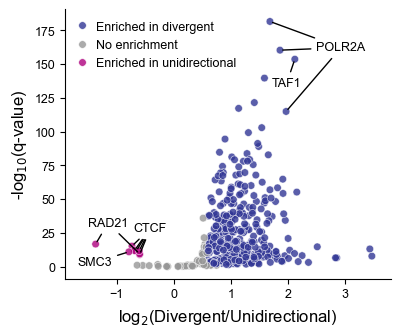

In [17]:
fig, ax = plt.subplots(figsize=(4.2,3.5))
plot_enrichment(df_enr[d], ax, [-1.9, 3.8])

# Add labels to highlight some proteins
for k in ns:
	if k in ["POLR2A", "TAF1"]:
		df_txt = df_enr[d][df_enr[d]["feature"]==k].sort_values(by=["log10.ttest.pval.adj", "log2fc.1vs2"], ascending=False)
	else:
		df_txt = df_enr[d][df_enr[d]["feature"]==k].sort_values(by=["log2fc.1vs2"])
	xs = df_txt["log2fc.1vs2"].head(ns[k])
	ys = df_txt["log10.ttest.pval.adj"].head(ns[k])
	
	for i, (x, y) in enumerate(zip(xs, ys)):
		xytext = {
			"POLR2A": (2.5, 160),
			"CTCF": (-0.7, 26),
			"RAD21": (-1.5, 30),
			"SMC3": (x-0.9, y-10),
		}.get(k, (x-0.4, y-20))
		color = "#FFFFFF" if k in ["POLR2A", "CTCF", "RAD21"] and i != ns[k]-1 else "#000000"
		ax.annotate(k, (x, y), xytext=xytext, arrowprops=dict(arrowstyle="-"), c=color, size=sfontsize)

plt.savefig(f"{PROJECT_DIR_o}figures/Fig1e.pdf", bbox_inches="tight", transparent=True) 

### Proximal

In [18]:
d = "proximal"

In [19]:
candidates = ["POLR2A", "TAF1", "RAD21", "SMC3", "CTCF", "SMAD5", "PHF8"]
ns2 = {}
for c in candidates:
	if c == "POLR2A":
		ns2[c] = 3
	else:
		ns2[c] = len(df_enr[d][df_enr[d]["feature"]==c])

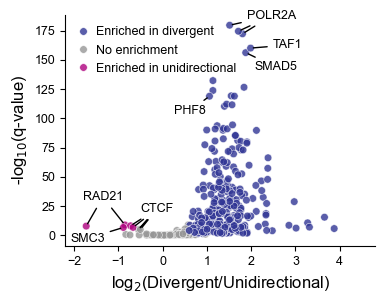

In [20]:
fig, ax = plt.subplots(figsize=(4,3))
plot_enrichment(df_enr[d], ax, [-2.2, 4.8])

# Add labels to highlight some proteins
for k in ns2:
	if k in ["POLR2A", "TAF1", "SMAD5", "PHF8"]:
		df_txt = df_enr[d][df_enr[d]["feature"]==k].sort_values(by=["log10.ttest.pval.adj", "log2fc.1vs2"], ascending=False)
	else:
		df_txt = df_enr[d][df_enr[d]["feature"]==k].sort_values(by=["log2fc.1vs2"])
	xs = df_txt["log2fc.1vs2"].head(ns2[k])
	ys = df_txt["log10.ttest.pval.adj"].head(ns2[k])

	for i, (x, y) in enumerate(zip(xs, ys)):
		xytext = {
			"POLR2A": (1.9, 185),
			"TAF1": (x+0.5, y),
			"PHF8": (x-0.8, y-15),
			"CTCF": (-0.5, 20),
			"RAD21": (-1.8, 30),
			"SMC3": (x-1.2, y-12),
		}.get(k, (x+0.2, y-15))
		
		if k in ["POLR2A", "CTCF", "RAD21"]:
			color = "#000000" if i == ns[k]-1 else "#FFFFFF"
		else:
			color = "#000000"
		ax.annotate(k, (x, y), xytext=xytext, arrowprops=dict(arrowstyle="-"), c=color, size=sfontsize)

plt.savefig(f"{PROJECT_DIR_o}figures/ExtDataFig1d.pdf", bbox_inches="tight", transparent=True) 